In [13]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pprint import pprint
import math
from scipy.io import arff

In [2]:
# params
seed = 42

Датасет содержит результаты качественной оценки корпоративных заемщиков 

In [30]:
data = arff.loadarff('Qualitative_Bankruptcy.arff')
df = pd.DataFrame(data[0])
for column in df.columns:
    df[column] = df[column].str.decode("UTF-8")
df

,IR,MR,FF,CR,CO,OP,Class
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB
...,...,...,...,...,...,...,...
245,N,N,A,N,N,N,B
246,P,N,N,N,N,N,B
247,A,N,N,N,N,N,B
248,N,N,N,N,N,N,B


Уже видим пропуски

### Список факторов:
|    | Variable Name   | Description                                        | Codings                             |
|---:|:----------------|:---------------------------------------------------|:------------------------------------|
|  0 | IR              | Industrial Risk                                    | (Identical for all variables below) |
|  1 |                 | Government policies and International agreements,  | P = positive                        |
|    |                 | 	Cyclicality,                                                     |                                     |
|    |                 | 	Degree of competition,				                                                    |                                     |
|    |                 | 	The price and stability of market supply,                                                    |                                     |
|    |                 | 	The size and growth of market demand,	                                                    |                                     |
|    |                 | 	The sensitivity to changes in macroeconomic factors,                                                    |                                     |
|    |                 | 	Domestic and international competitive power,                                                     |                                     |
|    |                 | 	Product Life Cycle.                                                    |                                     |
|  2 |                 |                                                    | A = average                         |
|  3 |                 |                                                    | N = negative                        |
|  4 | MR              | Management Risk:                                   |                                     |
|  5 |                 | Stability of management,                           |                                     |
|    |                 | 	The relationship between management/ owner,                                                     |                                     |
|    |                 | 	Human resources management,                                                     |                                     |
|    |                 | 	Growth process/business performance,                                                     |                                     |
|    |                 | 	Short and long term business planning,                                                     |                                     |
|    |                 | 	achievement and feasibility                                                    |                                     |
|  6 | FF              | Financial Flexibility                              |                                     |
|  7 |                 | Direct financing,                                  |                                     |
|    |                 | 	Indirect financing,                                                     |                                     |
|    |                 | 	Other financing                                                    |                                     |
|  8 | CR              | Credibility                                        |                                     |
|  9 |                 | Credit history,                                    |                                     |
|    |                 | 	reliability of information,                                                     |                                     |
|    |                 | 	The relationship with financial institutes                                                    |                                     |
| 10 | CO              | Competitiveness                                    |                                     |
| 11 |                 | Market position,                                   |                                     |
|    |                 | 	The level of core capacities,                                                     |                                     |
|    |                 | 	Differentiated strategy                                                    |                                     |
| 12 | OP              | Operating Risk                                     |                                     |
| 13 |                 | The stability and diversity of procurement,        |                                     |
|    |                 | 	The stability of transaction,                                                     |                                     |
|    |                 | 	The efficiency of production,                                                     |                                     |
|    |                 | 	The prospects for demand for product and service,                                                     |                                     |
|    |                 | 	Sales diversification,                                                    |                                     |
|    |                 | 	Sales price and settlement condition,                                                     |                                     |
|    |                 | 	Collection of A/R,                                                    |                                     |
|    |                 | 	Effectiveness of sale network                                                    |                                     |
| 14 | Class          | target                                             | NB = not bankrupt                   |
| 15 |                 |                                                    | B = bankrupt                        |

In [36]:
#get description of factors as tabulated markdown
df_names = pd.read_excel('description.xlsx', header = [0])
df_names = df_names.fillna("")
#print(df_names.to_markdown())

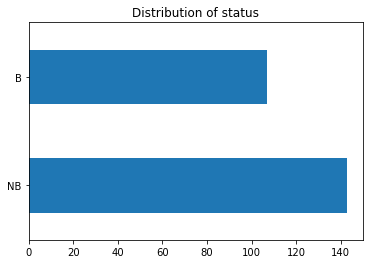

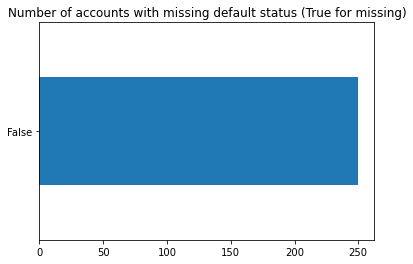

In [33]:
df.Class.value_counts().plot.barh()
plt.title("Distribution of status")
plt.show()

df.Class.isnull().value_counts().plot.barh()
plt.title("Number of accounts with missing default status (True for missing)")
plt.show()

Для единообразия нотации, создадим новую зависимую переменную target:

In [38]:
df.Class

0      NB
1      NB
2      NB
3      NB
4      NB
       ..
245     B
246     B
247     B
248     B
249     B
Name: Class, Length: 250, dtype: object

In [40]:
df["target"] = np.where(df.Class == "NB", 0, 1)
df.drop("Class", inplace = True, axis = 1)

Выделяем test&train сеты

In [41]:
X = df.loc[:, df.columns != 'target']
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


Сохраняем данные

In [ ]:
!pip install pyarrow
!pip install fastparquet

In [42]:
# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train.to_parquet('./samples/X_train.parquet')
X_test.to_parquet('./samples/X_test.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train).to_parquet('./samples/y_train.parquet')
pd.DataFrame(y_test).to_parquet('./samples/y_test.parquet')

#списки категориальных и количественных переменных
df_number_of_uniques = df.nunique()
presumably_continuous = df_number_of_uniques[df_number_of_uniques >= 15]
presumably_discrete = df_number_of_uniques[df_number_of_uniques < 15]

presumably_continuous_names = list(presumably_continuous.index)
presumably_discrete_names = list(presumably_discrete.index)

with open('factors.json', 'w') as f:
    json.dump({'cat_vals': presumably_discrete_names, "num_vals": presumably_continuous_names}, f)

A subdirectory or file samples already exists.


### Статистики

In [43]:
print(f'Количество наблюдений: {X.shape[0]}')
print(f'Количество наблюдений, где имеются данные о дефолте или его отсутствии: {X[y.isnull() == False].shape[0]}')
print(f'Количество факторов: {X.shape[1]}')
print(f'Количество целевых событий: {y.sum()}')
print(f'Доля целевых событий: {y.sum() / X[y.isnull() == False].shape[0] * 100}%')

Количество наблюдений: 250
Количество наблюдений, где имеются данные о дефолте или его отсутствии: 250
Количество факторов: 6
Количество целевых событий: 107
Доля целевых событий: 42.8%


### Пропуски

Пропусков в данных нет

In [44]:
for col in X.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X[col].isna().sum()} или {X[col].isna().sum() / df.shape[0] * 100}%')

Количество пропусков по фактору IR:
	0 или 0.0%
Количество пропусков по фактору MR:
	0 или 0.0%
Количество пропусков по фактору FF:
	0 или 0.0%
Количество пропусков по фактору CR:
	0 или 0.0%
Количество пропусков по фактору CO:
	0 или 0.0%
Количество пропусков по фактору OP:
	0 или 0.0%


### Визуальный анализ

Изготовим маску для осмысленного наименования факторов:

In [45]:
from pprint import pprint 
df_names_short = df_names[["Variable Name", "Description"]][(df_names["Variable Name"] != "")&(df_names["Description"] != "")]
short_names = df_names_short["Variable Name"]
short_names = short_names.str.upper()
meaningful_names = df_names_short["Description"]
names_mask = dict(zip(short_names, meaningful_names))

pprint(names_mask)

{'CO': 'Competitiveness',
 'CR': 'Credibility',
 'FF': 'Financial Flexibility',
 'IR': 'Industrial Risk',
 'MR': 'Management Risk:',
 'OP': 'Operating Risk',
 'TARGET': 'target'}


И маски для осмысленных обозначений кодов категориальных переменных:

In [46]:

cat_vals_all_mask = {
    "P" : "Positive",
    "N" : "Negative",
    "A" : "Average"
}

dict_of_masks = {
    "IR" : cat_vals_all_mask,
    "CO" : cat_vals_all_mask,
    "CR" : cat_vals_all_mask,
    "FF" : cat_vals_all_mask,
    "MR" : cat_vals_all_mask,
    "OP" : cat_vals_all_mask
}

In [47]:
X_cat = X.copy()
for col_name in dict_of_masks.keys():
    X_cat[col_name] = X_cat[col_name].replace(dict_of_masks[col_name])

categorical


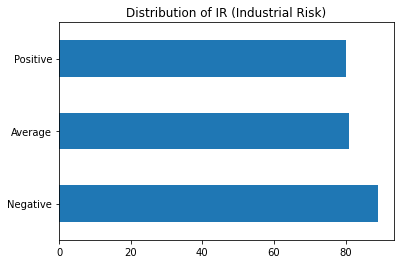

categorical


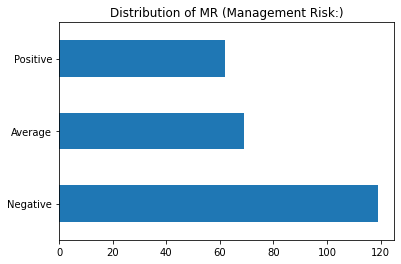

categorical


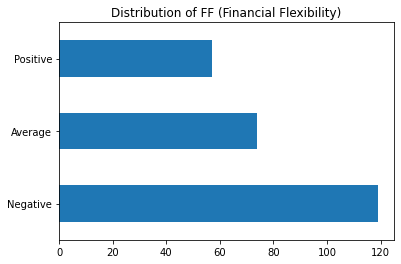

categorical


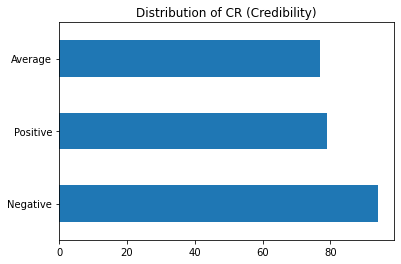

categorical


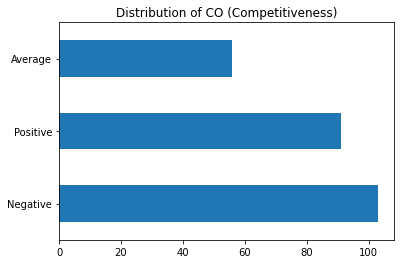

categorical


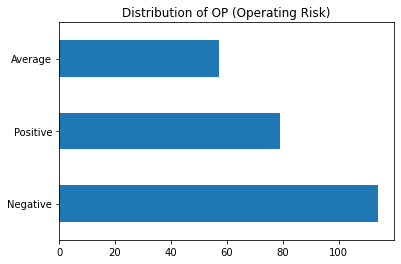

In [48]:
def plot_categorical(column, column_name, names_mask):
    column.value_counts().plot.barh()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_mixed(column, column_name, names_mask):
    print("This is a column mixed of both numeric and non-numeric values")
    check_numeric = column.str.isnumeric()
    check_numeric[check_numeric.isnull()] = True
    check_numeric[column.isnull()] = False

    plt.hist(column[check_numeric], orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]}) without non-numeric values')
    plt.show()

    check_numeric.value_counts().plot.barh()
    plt.title(f'Distribution of non-missing (numeric) values in {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_numeric(column, column_name, names_mask):
    plt.hist(column, orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()    

def plot_datetime(column, column_name, names_mask):
    column.hist()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()
    
def check_mixed_or_categorical(column):
    if is_string_dtype(column) == False:
        return(False)
    else:
        check_numeric = column.str.isnumeric()
        check_numeric[check_numeric.isnull()] = True
        check_numeric[column.isnull()] = False
        if len(column[check_numeric]) == 0:
            return("categorical")
        else:
            return("mixed")

def check_factor_plotting_type(column, column_name, names_mask):
    if column.dtype == pd.Series([np.datetime64("1995-05-05")]).dtype:
        return("datetime")
    elif check_mixed_or_categorical(column) != False:
        return(check_mixed_or_categorical(column))
    else:
        return("numeric")

def plot_all(column, column_name, names_mask, presumably_discrete_names = presumably_discrete_names):
    map_functions_to_types = {
        "categorical" : plot_categorical,
        "mixed" : plot_mixed,
        "numeric" : plot_numeric, 
        "datetime" : plot_datetime
    }
    
    type_checked = check_factor_plotting_type(column, column_name, names_mask)
    print(type_checked)
    map_functions_to_types[type_checked](column, column_name, names_mask)


for col in X_cat.columns:
    
    plot_all(X_cat[col], col, names_mask)


### Выбросы

В датасете все переменные - категориальные

### Выводы

Очень маленький датасет, содержащий только категориальные переменные. С одной стороны, в нем нет пропусков и выбросов и довольно большая доля целевых событий (почти 50%). С другой, надежды построить надежную модель для получения прогнозов с таким количеством наблюдений достаточно мало, тем более, что вряд ли качественные факторы предоставляют исчерпывающую информацию для такого прогноза, а возможности присоединить к нему дополнительные факторы нет за анонимностью данных.